Buiding Denoising Diffusion Model


In this HW, we practice using a simple Diffusion Model Python code that generates a flower image from random noise.

**Reference:**
- [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)

## Part 0. Downloading Dataset

Download the image dataset (Flower102) through torchvision. (*Provides approximately 8,000 learning samples)


100%|██████████| 344862509/344862509 [00:09<00:00, 38130223.31it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 827324.40it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14682023.04it/s]


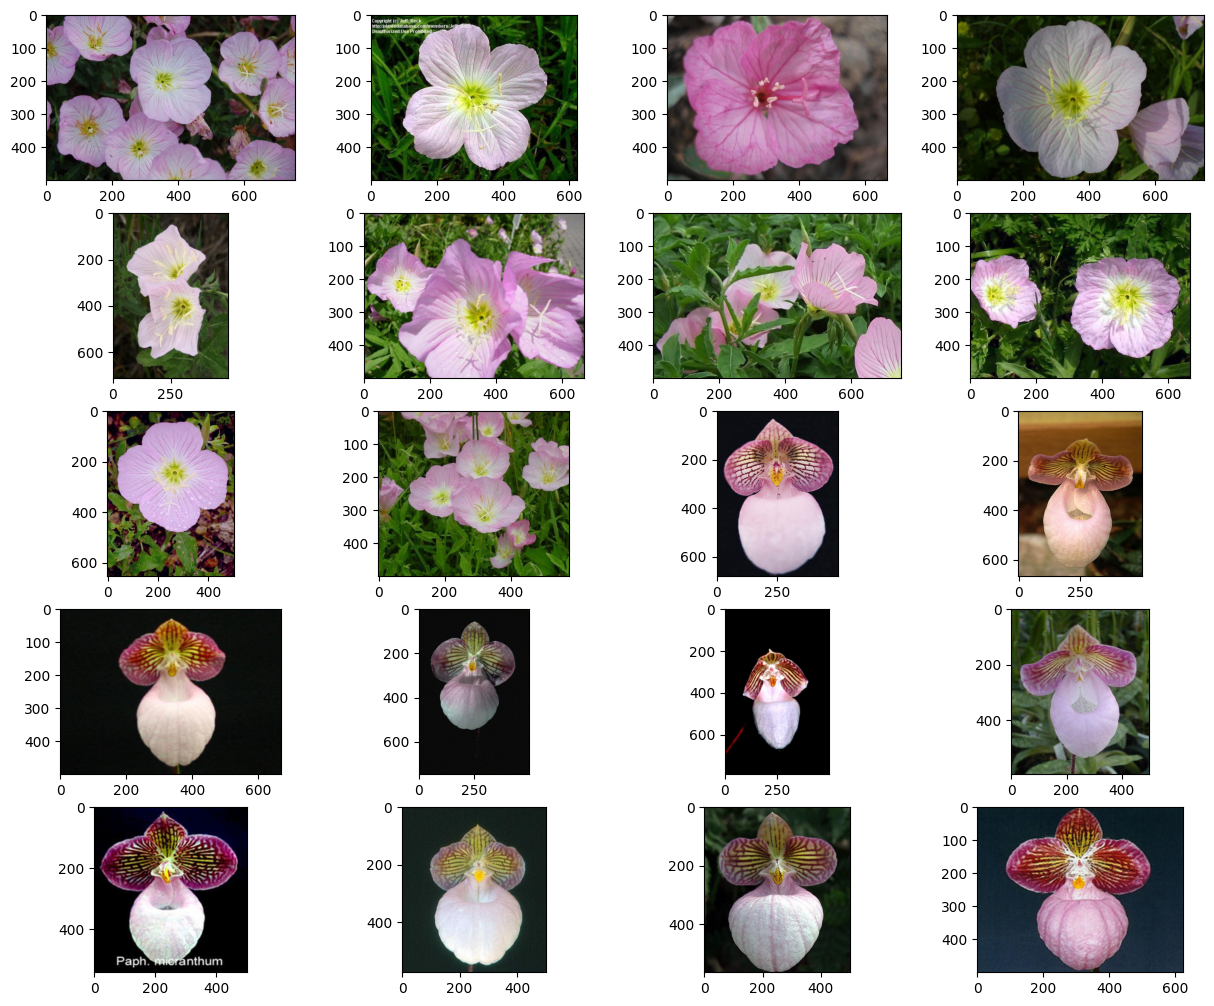

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.Flowers102(root='.',download=True)
show_images(data)

# Diffusion Model

# Part 1. Foward Process
The formula for the forward process is given as follows:

\begin{equation}
q(x_{t}|x_{t-1}) = \mathcal{N}(x_{t};\sqrt{1-\beta_{t}}x_{t-1},\beta_{t}\textbf{I})
\end{equation}

When a noisy image $x_{t-1}$ is given, $x_{t}$ is sampled using the Gaussian distribution.

Here, $\beta = {\beta_{1},\cdots,\beta_{T}}$ are constants used in the process of adding noise over T steps, and they represent the scheduling values that control this process.

The following formula represents the forward sampling process: ($\epsilon \sim \mathcal{N}(0,1)$)

\begin{equation}
x_{t} = \sqrt{1-\beta_{t}}x_{t-1} + \sqrt{\beta_{t}}*\epsilon
\end{equation}

Meanwhile, to obtain a sample at any arbitrary t, one can methodically proceed through each step using the previously defined formula. However, this can be re-expressed in one step as follows:

\begin{equation}
\alpha_{t} := 1 - \beta_{t} \hspace{0.5cm} \textrm{and} \hspace{0.5cm} \bar{\alpha}_{t} := \Pi_{s=1}^{t}\alpha_{s}
\end{equation}

\begin{equation}
q(x_{t}|x_{0}) =  \mathcal{N}(x_{t};\sqrt{\bar{\alpha}_{t}}x_{0},(1-\bar{\alpha}_{t})\textbf{I})
\end{equation}

# Practice
Therefore, from the original image $x_{0}$, the noisy image $x_{t}$ at step t can be represented as follows:

\begin{equation}
x_{t} = \sqrt{\bar{\alpha}_{t}}x_{0} + \sqrt{1-\bar{\alpha}_{t}}*\epsilon
\end{equation}

Let's complete the output below.

**입력**: $\beta_{t}$: 변수명 betas

**출력**:

- $\alpha_{t}$: alphas
- $\bar{\alpha}_{t}$: alphas_cumprod
- Forward Function $x_{t} = \sqrt{\bar{\alpha}_{t}}x_{0} + \sqrt{1-\bar{\alpha}_{t}}*\epsilon$: forward_diffusion_sample

In [3]:
import torch.nn.functional as F

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # Output
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Input beta schedule
start = 0.0001
end = 0.02
T = 300
betas = torch.linspace(start, end, T)
# betas = [start, start + (end-start)*(1/T), start + (end-start)*(2/T), start + (end-start)*(3/T), ..., end]

#________________Implementation Practice_________________________
# Hint: Definition of alpha
alphas = 1 - betas #TODO

# Hint: use function of torch.cumprod(X, axis=0). It returns the cumulative product of elements of input in the dimension dim
alphas_cumprod = torch.cumprod(alphas, axis=0) #TODO

# Make the square root of alphas_cumprod
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) #TODO

# Make the square root of 1 - alphas_cumprod
sqrt_one_minus_alphas_cumprod = torch.sqrt(1-alphas_cumprod) #TODO
#________________________________________________________________

# Settings for backward process (Do not modify this)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) #
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

## See the Result of Forward Process

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform)

    test = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

<ipython-input-5-d9f525c4d01f>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


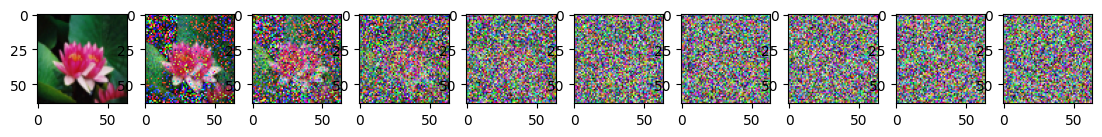

In [5]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    show_tensor_image(img)

# Part 2. Backward (Reverse) Process

The sampling in the backward process is given by $q(x_{t-1}|x_{t})$. However, since this sampling cannot be directly obtained, it is modeled through a Neural Network as follows:

\begin{equation}
q(x_{t-1}|x_{t}) = p_{\theta}(x_{t-1}|x_{t})
\end{equation}

This process leads to the learning of the following loss value through the derivation of the DDPM (Denoising Diffusion Probabilistic Model):

\begin{equation}
L_{t-1} = \mathbb{E}_{x_{0},\epsilon} [||\epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t}x_{0} + \sqrt{1 - \bar{\alpha}_{t}\epsilon}, t )||^2]
\end{equation}

Here, $\epsilon_{\theta}(\sqrt{\bar{\alpha}_t}x_{0} + \sqrt{1 - \bar{\alpha}_{t}\epsilon}, t )$ can be modeled by a Neural Network that takes $x_{0}$ and t as inputs.

# Practice

The code below represents a UNet structure of a Neural Network that can model $\epsilon_{\theta}(\sqrt{\bar{\alpha}t}x{0} + \sqrt{1 - \bar{\alpha}_{t}\epsilon}, t )$. Observe the code and complete the blanks."





**Model Description**:
- This is a UNet that can predict the noise added to an image.
- Therefore, the input is a Noisy image, and the output is Noise.
- Structure of the model:

**UNet Structure (dimension)**

**Input**: image (64 x64 x 3), Step t (1)

**Model Execution Order**

1. Image Encoding
2. Step Encoding

3. UNet:

- [downblock 1 => downblock 2 => downblock 3 => downblock 4]
- [upblock 1 => upblock 2 => upblock 3 => upblock 4]

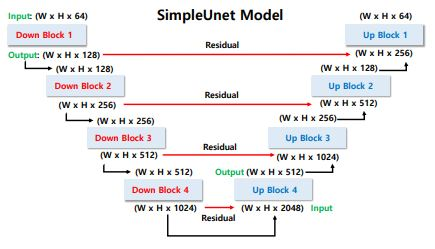

4. Noise Decoding




In [6]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)

        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## Part 3. Complete the Training Loss

\begin{equation}
L_{t-1} = \mathbb{E}_{x_{0},\epsilon} [||\epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t}x_{0} + \sqrt{1 - \bar{\alpha}_{t}\epsilon}, t )||^2]
\end{equation}

In [7]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)
    noise_pred = model(x_noisy, t)
    #________________Implementation Practice_________________________
    # Fill in the code of "[blank]" as given below:
    return F.l1_loss(noise_pred, noise) #TODO
    #________________________________________________________________


## Part 4. Sampling Images from the Trained Model


The function below continuously computes $p_{\theta}(x_{t-1}|x_{t})$ from the trained model $p_{\theta}$ and restores the image from arbitrary noise.

Therefore, it takes the Noisy image $x_{t}$ at step t and the step t as inputs, and generates the image $x_{t-1}$ at step t - 1."

In [8]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Train



Epoch 0 | step 000 Loss: 0.8118835687637329 


<ipython-input-8-23d9a600a066>:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


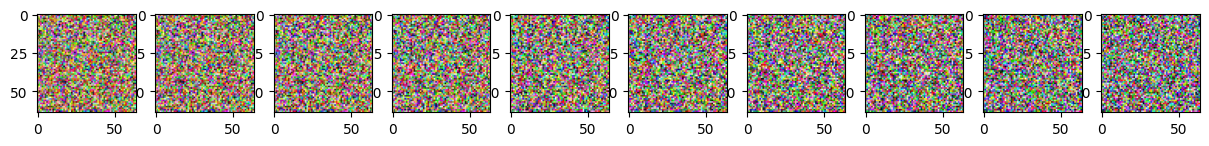

Epoch 3 | step 000 Loss: 0.2260618507862091 


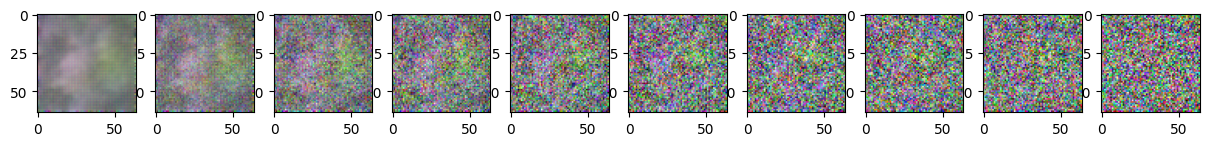

Epoch 6 | step 000 Loss: 0.19613902270793915 


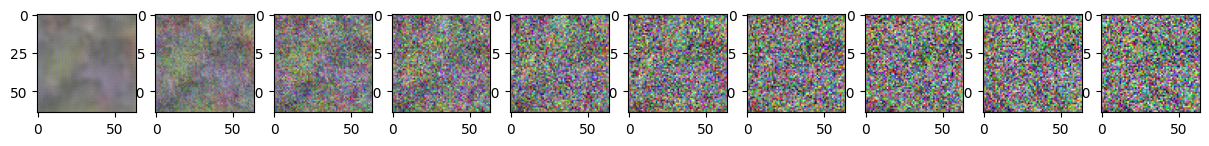

Epoch 9 | step 000 Loss: 0.1835041344165802 


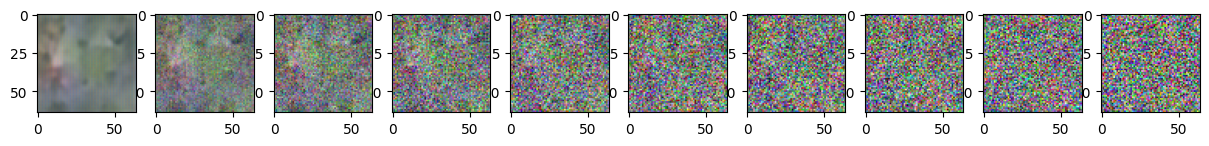

In [9]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 3 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()